In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from easy_model import *

In [4]:
limit_gpus()
set_gpu(1)

In [5]:
dataset = "mnist"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [6]:
x_train, y_train = get_raw_dat(ds_train)

In [36]:
_, y_test = get_raw_dat(ds_test)

In [7]:
xs, ys = next(iter(ds_train))

In [8]:
input_shape

(28, 28, 1)

In [9]:
model = PhasorModel(input_shape, onehot_offset=0.0, onehot_phase=0.5, max_step=0.05, projection="NP")

In [10]:
ys0 = model(xs)

(array([106., 113., 109., 111., 116., 131., 124., 160., 173., 137.]),
 array([-0.9991734 , -0.7996879 , -0.6002025 , -0.40071702, -0.20123157,
        -0.00174612,  0.19773933,  0.39722478,  0.59671026,  0.7961957 ,
         0.99568117], dtype=float32),
 <BarContainer object of 10 artists>)

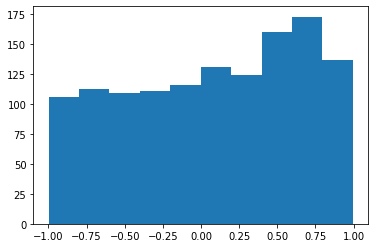

In [11]:
plt.hist(ys0.numpy().ravel())

In [12]:
model.compile(optimizer="rmsprop")

In [13]:
loss = model.train(ds_train, 2)

Training loss tf.Tensor(0.99601483, shape=(), dtype=float32)
Training loss tf.Tensor(0.044496346, shape=(), dtype=float32)
Training loss tf.Tensor(0.030093934, shape=(), dtype=float32)
Training loss tf.Tensor(0.019915387, shape=(), dtype=float32)
Training loss tf.Tensor(0.021762103, shape=(), dtype=float32)
Training loss tf.Tensor(0.019909628, shape=(), dtype=float32)
Training loss tf.Tensor(0.017853657, shape=(), dtype=float32)
Training loss tf.Tensor(0.017882109, shape=(), dtype=float32)
Training loss tf.Tensor(0.012975909, shape=(), dtype=float32)
Training loss tf.Tensor(0.014360265, shape=(), dtype=float32)


In [14]:
yh1 = model(xs)

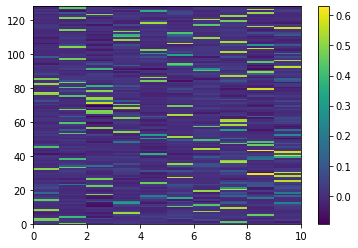

In [15]:
plt.pcolor(yh1)
plt.colorbar()

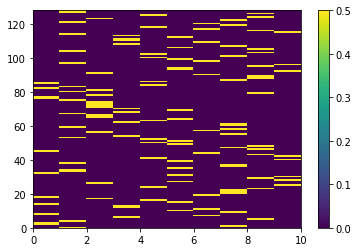

In [16]:
plt.pcolor(model.to_phase(ys))
plt.colorbar()

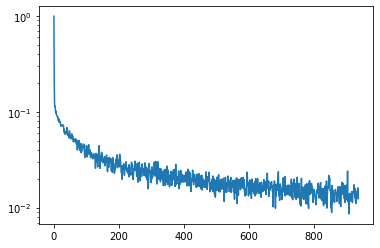

In [17]:
plt.semilogy(loss)

In [18]:
conf = model.accuracy(ds_test)

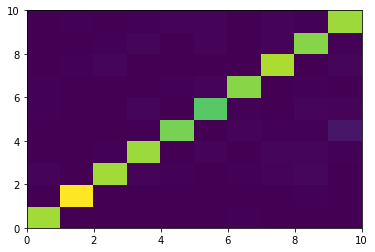

In [19]:
plt.pcolor(conf[0])

In [20]:
confusion_to_accuracy(conf)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9494>

In [51]:
small_test = tf.data.Dataset.from_tensor_slices((xs[0:10,...], ys[0:10,...]))
small_test = small_test.batch(10)

In [52]:
small_yhs = model.evaluate(small_test, method="dynamic")

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


In [23]:
small_yhs.shape

TensorShape([128, 10, 10])

In [56]:
model.predict(small_yhs, method="dynamic_mode").ravel() == ys[0:10,...]

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])>

In [64]:
preprocess = keras.Sequential([model.layers[0]])

In [65]:
input_spikes = model.phase_to_train(model.image_encoder(preprocess(xs[0:10,...])))

In [66]:
input_spikes[0]

(array([  0,   1,   2, ..., 781, 782, 783]),
 array([0.5728424 , 0.19892046, 0.4047272 , ..., 9.6923275 , 9.409106  ,
        9.575072  ], dtype=float32))

In [68]:
dpi=100

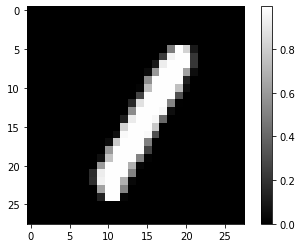

In [76]:
plt.imshow(xs[0,...], cmap="gray")
plt.colorbar()

Text(0.5, 1.0, 'Input Layer')

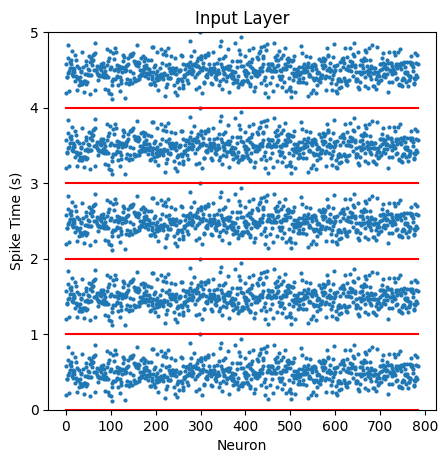

In [69]:
plt.figure(dpi=dpi, figsize=(5,5))
for i in range(10):
    plt.plot([0,784],[0.0+i,0+i], color="red")
plt.scatter(input_spikes[0][0], input_spikes[0][1], label="Input Spikes (Drive)", s=4)
#plt.scatter(dynamic_spikes[0][0], dynamic_spikes[0][1], label="Output Spikes (Response)")
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));

plt.xlabel("Neuron")
plt.ylabel("Spike Time (s)")
plt.ylim(0,5)
#plt.ylim(-0.5,10)
plt.title("Input Layer")

Text(0.5, 1.0, 'Dense 1')

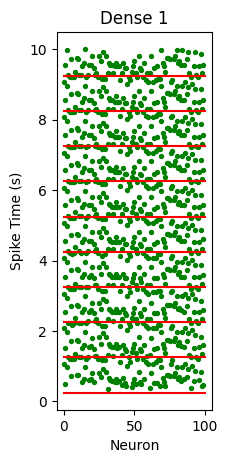

In [78]:
spk_layer1 = model.dense1.spike_trains
plt.figure(dpi=dpi, figsize=(2,5))
#plt.scatter(dynamic_input[0][0], dynamic_input[0][1], label="Input Spikes (Drive)")
for i in range(10):
    plt.plot([0,100],[0.25+i,0.25+i], color="red")
plt.scatter(spk_layer1[0][0], spk_layer1[0][1], label="Output Spikes (Response)", color="green", s=8)
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));
plt.xlabel("Neuron")
plt.ylabel("Spike Time (s)")
#plt.ylim(-0.5,10)
plt.title("Dense 1")

In [71]:
spk_layer2 = model.dense2.spike_trains

Text(0.5, 1.0, 'Dense 2')

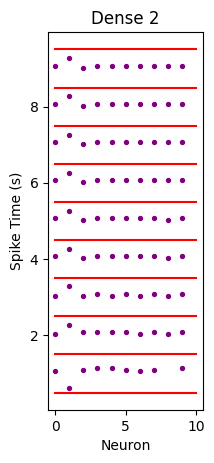

In [74]:
plt.figure(dpi=dpi, figsize=(2,5))
#plt.scatter(dynamic_input[0][0], dynamic_input[0][1], label="Input Spikes (Drive)")
for i in range(10):
    plt.plot([0,10],[0.50+i,0.50+i], color="red")
plt.scatter(spk_layer2[0][0], spk_layer2[0][1], label="Output Spikes (Response)", color="purple", s=8)
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));
plt.xlabel("Neuron")
plt.ylabel("Spike Time (s)")
#plt.ylim(-0.5,10)
plt.title("Dense 2")

In [25]:
np.mean(model.predict(small_yhs, method="dynamic_mode").ravel() == ys)

0.953125

In [26]:
np.mean(model.predict(small_yhs, method="dynamic_mean").ravel() == ys)

0.953125

In [30]:
model.image_encoder.norm_symbols.moving_mean

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.05011177], dtype=float32)>

In [33]:
all_yhs = model.evaluate(ds_test, method="dynamic")

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


In [34]:
all_yhs.shape

TensorShape([10000, 10, 10])

In [37]:
np.savez_compressed("mnist_yhs_dynamic.npz", yhs=all_yhs.numpy(), ys=y_test)

In [40]:
np.mean(model.predict(all_yhs, method="dynamic_mode").ravel() == y_test)

0.9467

In [41]:
np.mean(model.predict(all_yhs, method="dynamic_mean").ravel() == y_test)

0.9467

In [44]:
def train_and_save(num):
    model = PhasorModel(input_shape, 
                    onehot_offset=0.0, 
                    onehot_phase=0.5,
                    projection="NP",
                   
                   exec_time=5.0,
                   repeats=5,
                   max_step=0.02)
    model.compile(optimizer="rmsprop")
    loss = model.train(ds_train, 2)
    
    yh_static = model.evaluate(ds_test, method="static")
    yh_dynamic = model.evaluate(ds_test, method="dynamic")
    
    name = "mnist_model_"+str(num)+".npz"
    np.savez_compressed(name, 
                        yh_static=yh_static.numpy(),
                        yh_dynamic=yh_dynamic.numpy(),
                        ys=y_test.numpy())

In [45]:
train_and_save(5)

Training loss tf.Tensor(1.1027865, shape=(), dtype=float32)
Training loss tf.Tensor(0.042242173, shape=(), dtype=float32)
Training loss tf.Tensor(0.027328882, shape=(), dtype=float32)
Training loss tf.Tensor(0.024139293, shape=(), dtype=float32)
Training loss tf.Tensor(0.017027155, shape=(), dtype=float32)
Training loss tf.Tensor(0.016014883, shape=(), dtype=float32)
Training loss tf.Tensor(0.017927013, shape=(), dtype=float32)
Training loss tf.Tensor(0.013426544, shape=(), dtype=float32)
Training loss tf.Tensor(0.016903393, shape=(), dtype=float32)
Training loss tf.Tensor(0.013240361, shape=(), dtype=float32)


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


In [ ]:
for i in range(4):
    train_and_save(i)

Training loss tf.Tensor(0.7355691, shape=(), dtype=float32)
Training loss tf.Tensor(0.0414138, shape=(), dtype=float32)
Training loss tf.Tensor(0.02884664, shape=(), dtype=float32)
Training loss tf.Tensor(0.020415848, shape=(), dtype=float32)
Training loss tf.Tensor(0.01807487, shape=(), dtype=float32)
Training loss tf.Tensor(0.016070195, shape=(), dtype=float32)
Training loss tf.Tensor(0.02012305, shape=(), dtype=float32)
Training loss tf.Tensor(0.01105589, shape=(), dtype=float32)
Training loss tf.Tensor(0.014650123, shape=(), dtype=float32)
Training loss tf.Tensor(0.015350396, shape=(), dtype=float32)


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Training loss tf.Tensor(0.88640463, shape=(), dtype=float32)
Training loss tf.Tensor(0.036385942, shape=(), dtype=float32)
Training loss tf.Tensor(0.02726989, shape=(), dtype=float32)
Training loss tf.Tensor(0.028241556, shape=(), dtype=float32)
Training loss tf.Tensor(0.022143053, shape=(), dtype=float32)
Training loss tf.Tensor(0.016234966, shape=(), dtype=float32)
Training loss tf.Tensor(0.01915556, shape=(), dtype=float32)
Training loss tf.Tensor(0.015836399, shape=(), dtype=float32)
Training loss tf.Tensor(0.015480615, shape=(), dtype=float32)
Training loss tf.Tensor(0.012628876, shape=(), dtype=float32)


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Training loss tf.Tensor(0.6623397, shape=(), dtype=float32)
Training loss tf.Tensor(0.035598926, shape=(), dtype=float32)
Training loss tf.Tensor(0.026972722, shape=(), dtype=float32)
Training loss tf.Tensor(0.01758653, shape=(), dtype=float32)
Training loss tf.Tensor(0.017735658, shape=(), dtype=float32)
Training loss tf.Tensor(0.01793126, shape=(), dtype=float32)
Training loss tf.Tensor(0.015347942, shape=(), dtype=float32)
Training loss tf.Tensor(0.015430205, shape=(), dtype=float32)
Training loss tf.Tensor(0.015016308, shape=(), dtype=float32)
Training loss tf.Tensor(0.010979011, shape=(), dtype=float32)


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Training loss tf.Tensor(1.1045098, shape=(), dtype=float32)
Training loss tf.Tensor(0.041148685, shape=(), dtype=float32)
Training loss tf.Tensor(0.02673839, shape=(), dtype=float32)
Training loss tf.Tensor(0.023829194, shape=(), dtype=float32)
Training loss tf.Tensor(0.017580597, shape=(), dtype=float32)
Training loss tf.Tensor(0.0197622, shape=(), dtype=float32)
Training loss tf.Tensor(0.015742697, shape=(), dtype=float32)
Training loss tf.Tensor(0.020298526, shape=(), dtype=float32)
Training loss tf.Tensor(0.0152607, shape=(), dtype=float32)
Training loss tf.Tensor(0.011773767, shape=(), dtype=float32)


 95%|█████████▌| 122/128 [01:57<00:05,  1.03it/s]

In [47]:
train_and_save(4)

Training loss tf.Tensor(0.98066443, shape=(), dtype=float32)
Training loss tf.Tensor(0.048860334, shape=(), dtype=float32)
Training loss tf.Tensor(0.027566278, shape=(), dtype=float32)
Training loss tf.Tensor(0.024259765, shape=(), dtype=float32)
Training loss tf.Tensor(0.019768137, shape=(), dtype=float32)
Training loss tf.Tensor(0.0242156, shape=(), dtype=float32)
Training loss tf.Tensor(0.016052898, shape=(), dtype=float32)
Training loss tf.Tensor(0.014561225, shape=(), dtype=float32)
Training loss tf.Tensor(0.013656006, shape=(), dtype=float32)
Training loss tf.Tensor(0.009520875, shape=(), dtype=float32)


  4%|▍         | 5/128 [00:04<01:57,  1.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
for i in range(6,8):
    train_and_save(i)

Training loss tf.Tensor(1.1707141, shape=(), dtype=float32)
Training loss tf.Tensor(0.04247054, shape=(), dtype=float32)
Training loss tf.Tensor(0.03070863, shape=(), dtype=float32)
Training loss tf.Tensor(0.02118953, shape=(), dtype=float32)
Training loss tf.Tensor(0.016638193, shape=(), dtype=float32)
Training loss tf.Tensor(0.01389234, shape=(), dtype=float32)
Training loss tf.Tensor(0.013284197, shape=(), dtype=float32)
Training loss tf.Tensor(0.014917924, shape=(), dtype=float32)
Training loss tf.Tensor(0.016856175, shape=(), dtype=float32)
Training loss tf.Tensor(0.012287719, shape=(), dtype=float32)
